# 1.9. Putting it all together in a professional way

## Imports

In [1]:
import numpy as np # conda install numpy
import tensorflow as tf 
import matplotlib.pyplot as plt # conda install matplotlib
import pandas as pd # conda install pandas
import warnings
import seaborn as sns # conda install seaborn

warnings.filterwarnings('ignore')

print(tf.__version__)

2.4.1


## Load data and take a look at it

In [2]:
data = pd.read_csv('https://storage.googleapis.com/activation-function/csv/airbnb_new_york.csv').sample(frac=1)
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Data preprocessing

In [3]:
features = data[['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 
                 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
#print(features.isna().sum())
features['reviews_per_month'] = features['reviews_per_month'].fillna(0)
#print(features.isna().sum())

onehot_neighborhood_group = pd.get_dummies(features['neighbourhood_group'])
onehot_room_type = pd.get_dummies(features['room_type'])
#print(onehot_room_type)

features = features.drop(columns=['neighbourhood_group', 'room_type'])
features = pd.concat([features, onehot_neighborhood_group, onehot_room_type], axis=1)
#print(features.head())

targets = data['price']

train_size = int(0.7*len(data))
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

print(len(X_train[0]))

13


## Data visualization and analysis

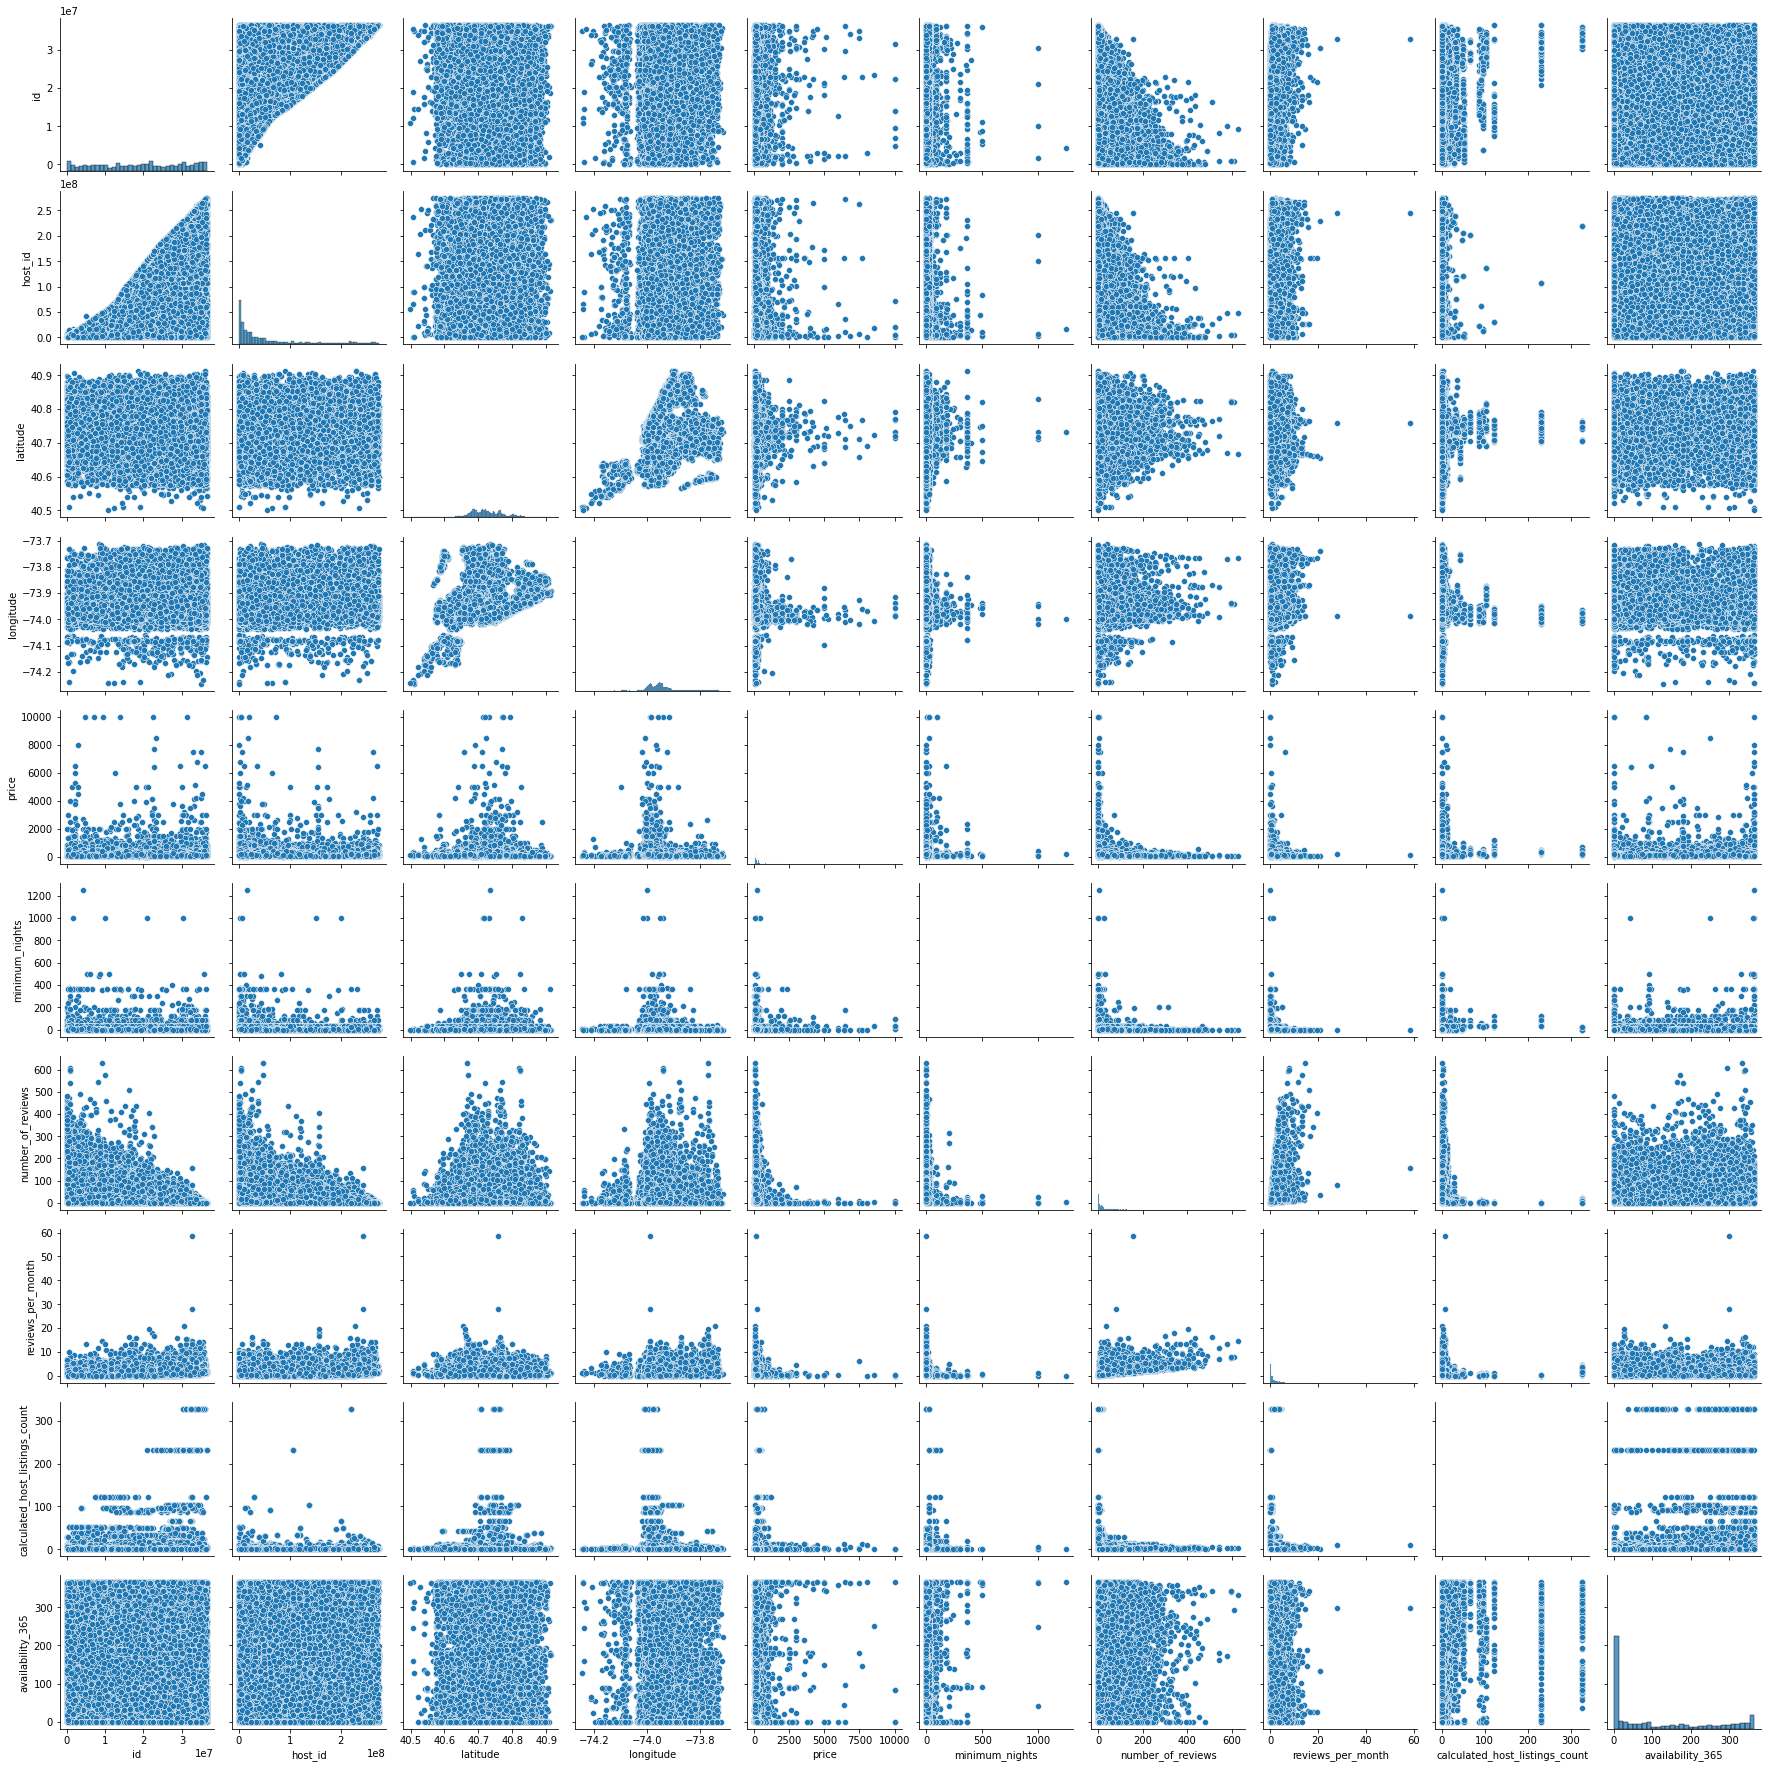

In [4]:
sns.pairplot(data)

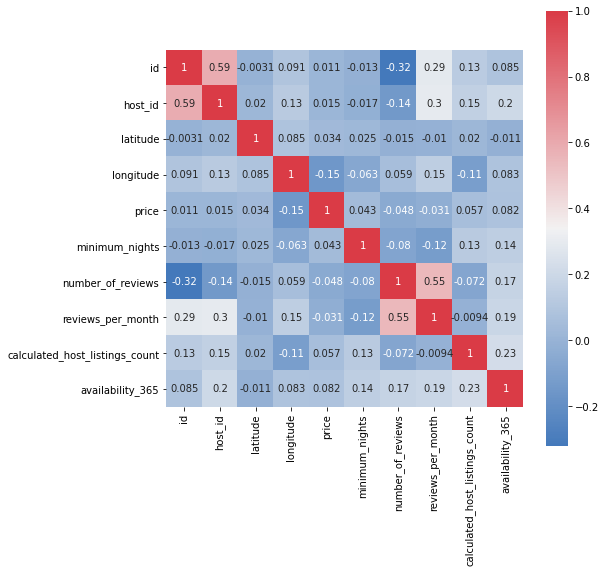

In [5]:
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
sns.heatmap(corr, square=True, cmap=cmap, annot=True)

## The TensorFlow 2 Machine Learning Approaches

## Multi Layer Perceptron (Artificial Neural Network)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), # 0 or x: _____/
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [7]:
def R_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1.0 - residual / total
    return r2

adam_optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MAE
model.compile(
    optimizer=adam_optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.MAE,
        tf.keras.metrics.MSE,
        R_squared, # -1 and 1, < 0 => useless, 0 and 1 => better close to 1
    ]
)

In [8]:
print(len(X_train[0]))
model.fit(X_train, y_train, epochs=10)
model.save('my ann.h5') 

13
Epoch 1/10
1070/1070 [==============================] - 2s 1ms/step - loss: 108.6622 - mean_absolute_error: 108.6622 - mean_squared_error: 56601.8404 - R_squared: -0.7839
Epoch 2/10
1070/1070 [==============================] - 1s 1ms/step - loss: 72.2016 - mean_absolute_error: 72.2016 - mean_squared_error: 53508.0898 - R_squared: 0.0893
Epoch 3/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.3371 - mean_absolute_error: 64.3371 - mean_squared_error: 43017.7972 - R_squared: 0.2286
Epoch 4/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.5799 - mean_absolute_error: 64.5799 - mean_squared_error: 46751.7746 - R_squared: 0.2452
Epoch 5/10
1070/1070 [==============================] - 1s 1ms/step - loss: 63.6478 - mean_absolute_error: 63.6478 - mean_squared_error: 43738.2570 - R_squared: 0.2518
Epoch 6/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.5462 - mean_absolute_error: 64.5462 - mean_squared_error: 43777.5009 - R_sq

In [12]:
y_test

array([155,  65, 250, ..., 160,  60, 180])

In [24]:
loaded_model = tf.keras.models.load_model('my ann.h5', custom_objects={"R_squared": R_squared})
print(loaded_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________
None


Previously, the loaded_model.evaluate method was throwing this error:

`TypeError: '<' not supported between instances of 'function' and 'str'`

To solve this, I added a compile of loaded_model before running loaded_model.evaluate.

See [StackOverflow](https://stackoverflow.com/questions/65549053/typeerror-not-supported-between-instances-of-function-and-str)

In [26]:
loaded_model.compile(
    optimizer=adam_optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.MAE,
        tf.keras.metrics.MSE,
        R_squared,
    ]
)

In [27]:
loaded_model.evaluate(X_test, y_test)

459/459 [==============================] - 1s 927us/step - loss: 64.4190 - mean_absolute_error: 64.4190 - mean_squared_error: 78267.0490 - R_squared: 0.2712


[62.545692443847656, 62.545692443847656, 59662.7109375, 0.2785426676273346]

In [10]:
print(loaded_model(X_test[:2]))
print(y_test[:2])

tf.Tensor(
[[146.1279  ]
 [ 52.945885]], shape=(2, 1), dtype=float32)
[155  65]


## Conclusions

* Sometimes the data set limits us WRT to results
* Data preprocessing and analysis is important - Tensorflow does not live in a bubble, it's a tool
* TF 2 simplifies many things: no more placeholders, eager execution, .numpy(), no more sessions, Keras has a bigger role
* ANNs are very sensitive to hyperparameter choice
* Running on GPU can help, but it's not a must
* You can do it!